### Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image

### Image Transformations

This cell defines preprocessing pipelines for the training and test images.
For training, various augmentations (such as flipping, rotation, color jitter, and affine transformation) are applied to increase data diversity and improve model generalization. Both pipelines convert images to grayscale, resize them to 224×224 pixels, convert them to tensors, and normalize the pixel values. The test set only uses basic preprocessing without augmentation to ensure fair evaluation.

In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


### Data Loading and Preparation

This section loads the brain tumor MRI image data from the specified directories using ImageFolder, applying the previously defined transforms. The training data is split into training and validation sets (85%/15%) to help monitor model performance. DataLoaders are then created for efficient batching and shuffling during training, validation, and testing. Finally, the class labels are displayed to confirm the dataset structure.

In [ ]:
# Adjust the paths below based on the actual location of your Training and Testing folders on your computer.
train_dir = r'C:\Users\hamih\OneDrive\Desktop\DataScience\personal projects\Brain-Tumor-MRI\Training'
test_dir = r'C:\Users\hamih\OneDrive\Desktop\DataScience\personal projects\Brain-Tumor-MRI\Testing'

full_train = datasets.ImageFolder(train_dir, transform=train_transform)
test_set = datasets.ImageFolder(test_dir, transform=test_transform)

# Split training into train/val
val_size = int(0.15 * len(full_train))
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

class_names = full_train.classes
print("Classes:", class_names)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Sample Image Visualization

A batch of MRI images with their class labels is visualized to confirm correct data loading and labeling before training.

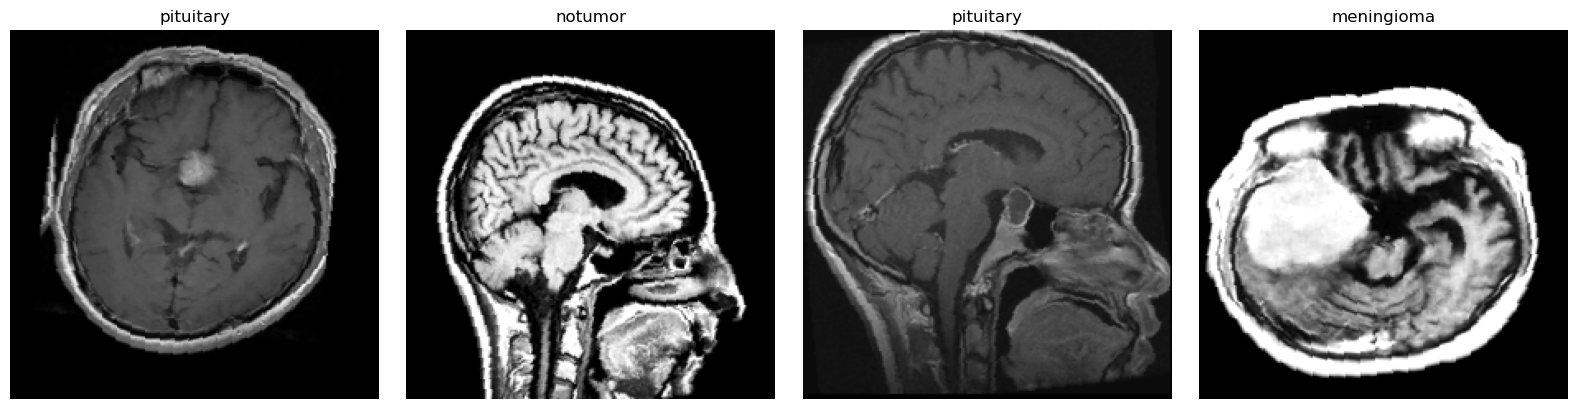

In [ ]:
def unnormalize(img_tensor):
    """
    Reverses normalization for grayscale images normalized with mean=0.5, std=0.5
    Input: PyTorch tensor with shape (1, H, W) or (H, W)
    Output: Numpy array with shape (H, W) in range [0,1]
    """
    img = img_tensor.numpy().squeeze()    # Remove channel if present
    img = img * 0.5 + 0.5                 # Reverse normalization
    img = np.clip(img, 0, 1)              # Ensure values are valid
    return img

# Get a batch from your DataLoader 
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot first 4 images in a row 
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    img = unnormalize(images[i].cpu())    # move to cpu just in case
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()


### Custom CNN Model Definition

A deep convolutional neural network (BrainTumorCNN) is defined for brain tumor MRI image classification. The architecture uses five convolutional blocks with batch normalization, ReLU activation, and max pooling to extract image features, followed by a fully connected classifier with dropout for regularization. The model is set up for four output classes and uses GPU acceleration if available.

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),  # 224/(2^5)=7
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN(num_classes=4).to(device)


### Loss Function and Optimizer Setup

The random seed is set for reproducibility, the loss function (CrossEntropyLoss) is chosen for multi-class classification, and the Adam optimizer is initialized with a learning rate of 1e-4. This learning rate is a common default for Adam, offering a good balance between stable convergence and efficient training in deep neural networks.

In [6]:
torch.manual_seed(101)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Training and Validation Loop

The model is trained for 20 epochs, with both training and validation losses and accuracies monitored throughout the process. After each epoch, key metrics are displayed, and the model state with the highest validation accuracy is saved. By the end of training, the custom CNN achieves over 97% training accuracy and approximately 96% validation accuracy, along with low loss values. This strong performance indicates that the model is highly effective at distinguishing between different brain tumor types in MRI images and is generalizing well to new, unseen data.

In [ ]:
epochs = 20
train_losses = []
val_losses = []
train_correct = []
val_correct = []
best_val_acc = 0

for epoch in range(epochs):
    trn_corr = 0
    val_corr = 0

    # Training loop
    model.train()
    total_train = 0
    running_train_loss = 0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        predicted = torch.max(y_pred.data, 1)[1]
        trn_corr += (predicted == y_train).sum().item()
        running_train_loss += loss.item() * y_train.size(0)
        total_train += y_train.size(0)
    avg_train_loss = running_train_loss / total_train
    avg_train_acc = trn_corr / total_train
    train_losses.append(avg_train_loss)
    train_correct.append(avg_train_acc)

    # Validation
    model.eval()
    total_val = 0
    running_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            predicted = torch.max(y_pred.data, 1)[1]
            val_corr += (predicted == y_val).sum().item()
            running_val_loss += loss.item() * y_val.size(0)
            total_val += y_val.size(0)
    avg_val_loss = running_val_loss / total_val
    avg_val_acc = val_corr / total_val
    val_losses.append(avg_val_loss)
    val_correct.append(avg_val_acc)

    # Save best model 
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), 'best_brain_tumor_cnn.pth')

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

Epoch 1/20: Train Loss: 0.9227, Acc: 0.6378 | Val Loss: 0.5941, Acc: 0.7687
Epoch 2/20: Train Loss: 0.5349, Acc: 0.7904 | Val Loss: 0.6619, Acc: 0.7196
Epoch 3/20: Train Loss: 0.4129, Acc: 0.8449 | Val Loss: 0.3883, Acc: 0.8668
Epoch 4/20: Train Loss: 0.3409, Acc: 0.8742 | Val Loss: 1.0957, Acc: 0.6647
Epoch 5/20: Train Loss: 0.2979, Acc: 0.8882 | Val Loss: 0.2848, Acc: 0.8995
Epoch 6/20: Train Loss: 0.2604, Acc: 0.9063 | Val Loss: 0.2797, Acc: 0.9182
Epoch 7/20: Train Loss: 0.2392, Acc: 0.9090 | Val Loss: 0.2381, Acc: 0.9194
Epoch 8/20: Train Loss: 0.2080, Acc: 0.9238 | Val Loss: 0.3547, Acc: 0.8715
Epoch 9/20: Train Loss: 0.1885, Acc: 0.9329 | Val Loss: 0.1621, Acc: 0.9416
Epoch 10/20: Train Loss: 0.1671, Acc: 0.9372 | Val Loss: 0.1661, Acc: 0.9439
Epoch 11/20: Train Loss: 0.1466, Acc: 0.9475 | Val Loss: 0.1475, Acc: 0.9474
Epoch 12/20: Train Loss: 0.1450, Acc: 0.9473 | Val Loss: 0.1294, Acc: 0.9568
Epoch 13/20: Train Loss: 0.1188, Acc: 0.9578 | Val Loss: 0.1543, Acc: 0.9404
Epoch 14

### Training and Validation Loss Curves
Training and validation loss are plotted over epochs to track the model’s learning process. The consistent decrease and stabilization of both losses indicate that the model is training effectively and generalizing well to the validation data.

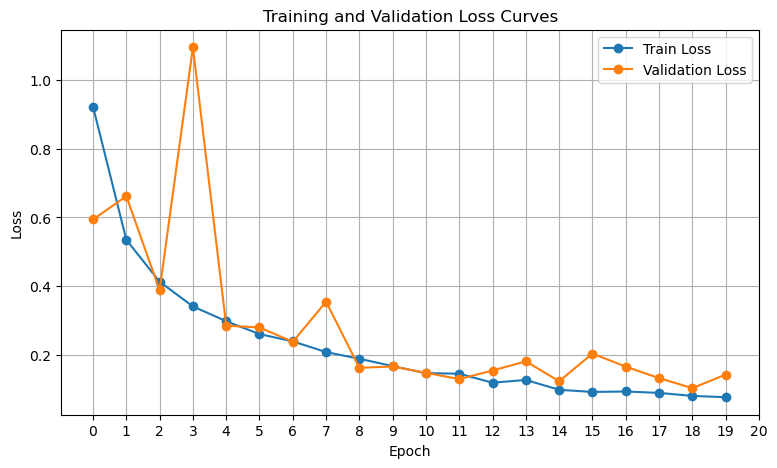

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)


plt.xticks(range(0, len(train_losses)+1))  

plt.show()


### Test Set Evaluation
The best saved model is loaded and evaluated on the test set to assess final performance. The model achieves a test loss of 0.0793 and a test accuracy of 97.4%, confirming excellent generalization and robust classification of brain tumor MRI images on unseen data.

In [ ]:
# Evaluate on test set
model.load_state_dict(torch.load('best_brain_tumor_cnn.pth'))
model.eval()
test_corr = 0
total_test = 0
running_test_loss = 0
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        predicted = torch.max(y_pred.data, 1)[1]
        test_corr += (predicted == y_test).sum().item()
        running_test_loss += loss.item() * y_test.size(0)
        total_test += y_test.size(0)
        all_test_labels.extend(y_test.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_acc = test_corr / total_test
avg_test_loss = running_test_loss / total_test
print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


C:\Users\hamih\AppData\Local\Temp\ipykernel_31076\3677408433.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_brain_tumor_cnn.pth')

Test Loss: 0.0793 | Test Accuracy: 0.9741


### Test Set Confusion Matrix
The confusion matrix summarizes the model’s classification performance across all brain tumor classes on the test set. Most predictions are correct, with only a few misclassifications, confirming high accuracy and reliable distinction between glioma, meningioma, pituitary tumor, and no tumor cases.

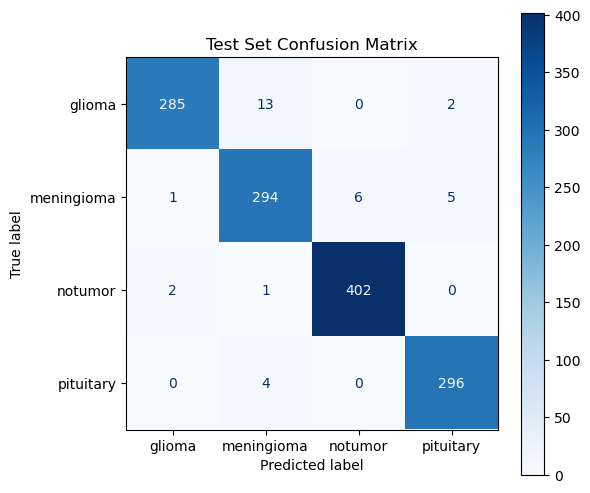

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_test_labels, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Test Set Confusion Matrix")
plt.show()